In [6]:
%matplotlib inline
import numpy as np
from random import sample, shuffle
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import pairwise_distances
import math
import random

In [7]:
def getPopulation(n_cities, n_individuals):
    population = []
    n = 0
    while n < n_individuals:
        individuals = np.random.permutation(n_cities)
        if not any([np.array_equal(individuals, x) for x in population]):
            population.append(individuals)
            n += 1
    return population

In [8]:
def Innovation(individual):
    innovated = np.array(individual)
    innovated = np.random.shuffle(innovated)
    return innovated

In [9]:
def Mutation(individual):
    mutated = np.array(individual)
    indi1,indi2 = sample(range(len(individual)),2)
    mutated[indi1] = individual[indi2]
    mutated[indi2] = individual[indi1]
    return mutated

In [10]:
def Inversion(individual):
    p = np.random.randint(n_cities)
    k = np.random.randint(p,n_cities)
    inverted = np.array(individual)
    if p == k:
        return None
    else:
        inverted[p:k] = reversed(inverted[p:k])
        return inverted

In [11]:
def Cloning(individual1, individual2):
    n = len(individual1)
    individual1, individual2 = sample(range(n),2)
    result1 = np.array(individual1)
    result2 = np.array(individual2)
    result2 = result2.tolist()
    result1 = result1.tolist()
    result2 = []
    for i in range((result1)):
        result2.append(result1)
    #result2 = result1.copy()
    return result1, result2

In [12]:
def Transposition(individual):
    transpo = np.array(individual)
    p = np.random.randint(n_cities)
    k = np.random.randint(p,n_cities)
    transpo[p:k] = shuffle(transpo[p:k])
    return transpo

In [13]:
def Crossing_over(individual1, individual2):
    n = len(individual1)
    cross_point1, cross_point2 = sample(range(n),2)
    if cross_point1 > cross_point2:
        tmp = cross_point2
        cross_point1 = cross_point2
        cross_point2 = tmp
    result1 = np.array(individual1)
    result2 = np.array(individual2)
    j1 = cross_point1
    j2 = cross_point2
    for i in range(cross_point1,cross_point2):
        while individual2[j1] not in individual1[cross_point1:cross_point2]:
            j1 = (j1+1)%n
        result1[i] = individual2[j1]
        j1 = (j1+1)%n
        while individual1[j2] not in individual2[cross_point1:cross_point2]:
            j2 = (j2+1)%n
        result2[i] = individual1[j2]
        j2 = (j2+1)%n
    return result1, result2

In [14]:
def createOffspring(individual, p_innovation = 0, p_mutation=0, p_inversion = 0, 
                   p_cloning = 0, p_transposition = 0, p_crossing_over = 0):
    offspring = []

    for x in individual:
        if np.random.rand() <= p_mutation:
            c = Mutation(x)
            if (not any([np.array_equal(c, x) for x in individual]) and 
                not any([np.array_equal(c, x) for x in offspring])):
                offspring.append(c)
        if np.random.rand() <= p_innovation:
            k = Innovation(x)
            if (not any([np.array_equal(k, x) for x in individual]) and 
                not any([np.array_equal(k, x) for x in offspring])):
                offspring.append(k)
        if np.random.rand() <= p_inversion:
            t = Inversion(x)
            if (not any([np.array_equal(t, x) for x in individual]) and 
                not any([np.array_equal(t, x) for x in offspring])):
                offspring.append(t)
        if np.random.rand() <= p_transposition:
            w = Transposition(x)
            if (not any([np.array_equal(w, x) for x in individual]) and 
                not any([np.array_equal(w, x) for x in offspring])):
                offspring.append(w)
    if np.random.rand() <= p_crossing_over:
        for i in range(len(individual)):
            p1, p2 = sample(individual, 2)
            c1, c2 = Crossing_over(p1, p2)
            if (not any([np.array_equal(c1, x) for x in individual]) and 
                not any([np.array_equal(c1, x) for x in offspring])):
                offspring.append(c1)
            if (not any([np.array_equal(c2, x) for x in individual]) and 
                not any([np.array_equal(c2, x) for x in offspring])):
                offspring.append(c2)
    
    if np.random.rand() <= p_cloning:
        for i in range(len(individual)):
            p1, p2 = sample(individual, 2)
            c1, c2 = Cloning(p1, p2)
            if (not any([np.array_equal(c1, x) for x in individual]) and 
                not any([np.array_equal(c1, x) for x in offspring])):
                offspring.append(c1)
            if (not any([np.array_equal(c2, x) for x in individual]) and 
                not any([np.array_equal(c2, x) for x in offspring])):
                offspring.append(c2)

    return offspring

In [15]:
def fitness(individual):   
    fitness = 0
    global distances
    
    for i in range(len(individual) - 1):
        fitness += distances[individual[i]][individual[i+1]]
    return fitness

In [16]:
def probabilisticSelection(population, selection_factor, p=[1, 0]):
    total_fitness = sum([fitness(x) for x in population])
    
    population = [[x, (p[0]*(total_fitness - fitness(x))+p[1])/(p[0]*(total_fitness*(len(population)-1))+p[1])] for x in population]
    population.sort(key=lambda x: x[1])
    population = [[x[0], y] for x, y in zip(population, np.cumsum([x[1] for x in population]))]

    new_population = []

    r = np.random.rand()
    for i in range(selection_factor):
        selected_individual = [x for x in population if x[1] >= (r + i/selection_factor)%1][0]
        new_population.append(selected_individual[0])

    return new_population

In [17]:
def elitismReplacement(individual, offspring, n_elite):
    individual.sort(key=lambda x: fitness(x))
    new_population = individual[:n_elite]
    offspring.sort(key=lambda x: fitness(x))
    new_population.extend(offspring[:(len(individual) - n_elite)])
    return new_population

In [18]:
def update(i, p_innovation, p_mutation, p_inversion, p_cloning, p_transposition, p_crossing_over):
    global population
    #population = getPopulation(n_cities, n_individuals)
    parents = probabilisticSelection(population, 150)
    offspring = createOffspring(parents, p_innovation, p_mutation, p_inversion, 
                   p_cloning, p_transposition, p_crossing_over)
    population = elitismReplacement(population, offspring, 100)
    
    best = min(population, key=lambda x: fitness(x))
    plotdata = [cities[x] for x in best]
    
    return plotdata

In [19]:
def distance_function(lists):
    p = []
    x,y = zip(*lists)
    for i in range(len(x)):
        l =  math.sqrt((x[i]-x[i-1])**2+(y[i]-y[i-1])**2)
        p.append(l)
    return p

In [20]:
n_cities = 15
n_individuals = 300

cities = ([(np.random.randn(),np.random.randn()) for x in range(0,n_cities)])
distances = pairwise_distances(cities, metric='euclidean')

### Primeiro parâmetro

In [21]:
population = getPopulation(n_cities, n_individuals)
k1 = []
for i in range(200):
    k1.append(update(i, 0, 0.2, 0, 0, 0, 0.2))

In [22]:
population = getPopulation(n_cities, n_individuals)
k2 = []
for i in range(200):
    k2.append(update(i, 0, 0.2, 0, 0, 0, 0.2))

In [23]:
population = getPopulation(n_cities, n_individuals)
k3 = []
for i in range(200):
    k3.append(update(i, 0, 0.2, 0, 0, 0, 0.2))

In [24]:
population = getPopulation(n_cities, n_individuals)
k4 = []
for i in range(200):
    k4.append(update(i, 0, 0.2, 0, 0, 0, 0.2))

In [25]:
population = getPopulation(n_cities, n_individuals)
k5 = []
for i in range(200):
    k5.append(update(i, 0, 0.2, 0, 0, 0, 0.2))

In [26]:
population = getPopulation(n_cities, n_individuals)
k6 = []
for i in range(200):
    k6.append(update(i, 0, 0.2, 0, 0, 0, 0.2))

In [27]:
population = getPopulation(n_cities, n_individuals)
k7 = []
for i in range(200):
    k7.append(update(i, 0, 0.2, 0, 0, 0, 0.2))

In [28]:
population = getPopulation(n_cities, n_individuals)
k8 = []
for i in range(200):
    k8.append(update(i, 0, 0.2, 0, 0, 0, 0.2))

In [29]:
population = getPopulation(n_cities, n_individuals)
k9 = []
for i in range(200):
    k9.append(update(i, 0, 0.2, 0, 0, 0, 0.2))

In [30]:
population = getPopulation(n_cities, n_individuals)
k10 = []
for i in range(200):
    k10.append(update(i, 0, 0.2, 0, 0, 0, 0.2))

In [31]:
population = getPopulation(n_cities, n_individuals)
k11 = []
for i in range(200):
    k11.append(update(i, 0, 0.2, 0, 0, 0, 0.2))

In [32]:
population = getPopulation(n_cities, n_individuals)
k12 = []
for i in range(200):
    k12.append(update(i, 0, 0.2, 0, 0, 0, 0.2))

In [33]:
population = getPopulation(n_cities, n_individuals)
k13 = []
for i in range(200):
    k13.append(update(i, 0, 0.2, 0, 0, 0, 0.2))

In [34]:
population = getPopulation(n_cities, n_individuals)
k14 = []
for i in range(200):
    k14.append(update(i, 0, 0.2, 0, 0, 0, 0.2))

In [35]:
population = getPopulation(n_cities, n_individuals)
k15 = []
for i in range(200):
    k15.append(update(i, 0, 0.2, 0, 0, 0, 0.2))

In [36]:
population = getPopulation(n_cities, n_individuals)
k16 = []
for i in range(200):
    k16.append(update(i, 0, 0.2, 0, 0, 0, 0.2))

In [37]:
population = getPopulation(n_cities, n_individuals)
k17 = []
for i in range(200):
    k17.append(update(i, 0, 0.2, 0, 0, 0, 0.2))

In [38]:
population = getPopulation(n_cities, n_individuals)
k18 = []
for i in range(200):
    k18.append(update(i, 0, 0.2, 0, 0, 0, 0.2))

In [39]:
population = getPopulation(n_cities, n_individuals)
k19 = []
for i in range(200):
    k19.append(update(i, 0, 0.2, 0, 0, 0, 0.2))

In [40]:
population = getPopulation(n_cities, n_individuals)
k20 = []
for i in range(200):
    k20.append(update(i, 0, 0.2, 0, 0, 0, 0.2))

### Segundo Parametro

In [47]:
population = getPopulation(n_cities, n_individuals)
k21 = []
for i in range(200):
    k21.append(update(i, 0, 0.1, 0, 0, 0, 0.4))

In [48]:
population = getPopulation(n_cities, n_individuals)
k22 = []
for i in range(200):
    k22.append(update(i, 0, 0.1, 0, 0, 0, 0.4))

In [49]:
population = getPopulation(n_cities, n_individuals)
k23 = []
for i in range(200):
    k23.append(update(i, 0, 0.1, 0, 0, 0, 0.4))

In [50]:
population = getPopulation(n_cities, n_individuals)
k24 = []
for i in range(200):
    k24.append(update(i, 0, 0.1, 0, 0, 0, 0.4))

In [51]:
population = getPopulation(n_cities, n_individuals)
k25 = []
for i in range(200):
    k25.append(update(i, 0, 0.1, 0, 0, 0, 0.4))

In [52]:
population = getPopulation(n_cities, n_individuals)
k26 = []
for i in range(200):
    k26.append(update(i, 0, 0.1, 0, 0, 0, 0.4))

In [53]:
population = getPopulation(n_cities, n_individuals)
k27 = []
for i in range(200):
    k27.append(update(i, 0, 0.1, 0, 0, 0, 0.4))

In [54]:
population = getPopulation(n_cities, n_individuals)
k28 = []
for i in range(200):
    k28.append(update(i, 0, 0.1, 0, 0, 0, 0.4))

In [55]:
population = getPopulation(n_cities, n_individuals)
k29 = []
for i in range(200):
    k29.append(update(i, 0, 0.1, 0, 0, 0, 0.4))

In [56]:
population = getPopulation(n_cities, n_individuals)
k30 = []
for i in range(200):
    k30.append(update(i, 0, 0.1, 0, 0, 0, 0.4))

In [57]:
population = getPopulation(n_cities, n_individuals)
k31 = []
for i in range(200):
    k31.append(update(i, 0, 0.1, 0, 0, 0, 0.4))

In [58]:
population = getPopulation(n_cities, n_individuals)
k32 = []
for i in range(200):
    k32.append(update(i, 0, 0.1, 0, 0, 0, 0.4))

In [59]:
population = getPopulation(n_cities, n_individuals)
k33 = []
for i in range(200):
    k33.append(update(i, 0, 0.1, 0, 0, 0, 0.4))

In [60]:
population = getPopulation(n_cities, n_individuals)
k34 = []
for i in range(200):
    k34.append(update(i, 0, 0.1, 0, 0, 0, 0.4))

In [61]:
population = getPopulation(n_cities, n_individuals)
k35 = []
for i in range(200):
    k35.append(update(i, 0, 0.1, 0, 0, 0, 0.4))

In [62]:
population = getPopulation(n_cities, n_individuals)
k36 = []
for i in range(200):
    k36.append(update(i, 0, 0.1, 0, 0, 0, 0.4))

In [63]:
population = getPopulation(n_cities, n_individuals)
k37 = []
for i in range(200):
    k37.append(update(i, 0, 0.1, 0, 0, 0, 0.4))

In [64]:
population = getPopulation(n_cities, n_individuals)
k38 = []
for i in range(200):
    k38.append(update(i, 0, 0.1, 0, 0, 0, 0.4))

In [65]:
population = getPopulation(n_cities, n_individuals)
k39 = []
for i in range(200):
    k39.append(update(i, 0, 0.1, 0, 0, 0, 0.4))

In [66]:
population = getPopulation(n_cities, n_individuals)
k40 = []
for i in range(200):
    k40.append(update(i, 0, 0.1, 0, 0, 0, 0.4))

### Terceiro parâmetro

In [67]:
population = getPopulation(n_cities, n_individuals)
k41 = []
for i in range(200):
    k41.append(update(i, 0, 0.5, 0, 0, 0, 0.3))

In [68]:
population = getPopulation(n_cities, n_individuals)
k42 = []
for i in range(200):
    k42.append(update(i, 0, 0.5, 0, 0, 0, 0.3))

In [69]:
population = getPopulation(n_cities, n_individuals)
k43 = []
for i in range(200):
    k43.append(update(i, 0, 0.5, 0, 0, 0, 0.3))

In [70]:
population = getPopulation(n_cities, n_individuals)
k44 = []
for i in range(200):
    k44.append(update(i, 0, 0.5, 0, 0, 0, 0.3))

In [71]:
population = getPopulation(n_cities, n_individuals)
k45 = []
for i in range(200):
    k45.append(update(i, 0, 0.5, 0, 0, 0, 0.3))

In [72]:
population = getPopulation(n_cities, n_individuals)
k46 = []
for i in range(200):
    k46.append(update(i, 0, 0.5, 0, 0, 0, 0.3))

In [73]:
population = getPopulation(n_cities, n_individuals)
k47 = []
for i in range(200):
    k47.append(update(i, 0, 0.5, 0, 0, 0, 0.3))

In [74]:
population = getPopulation(n_cities, n_individuals)
k48 = []
for i in range(200):
    k48.append(update(i, 0, 0.5, 0, 0, 0, 0.3))

In [75]:
population = getPopulation(n_cities, n_individuals)
k49 = []
for i in range(200):
    k49.append(update(i, 0, 0.5, 0, 0, 0, 0.3))

In [76]:
population = getPopulation(n_cities, n_individuals)
k50 = []
for i in range(200):
    k50.append(update(i, 0, 0.5, 0, 0, 0, 0.3))

In [77]:
population = getPopulation(n_cities, n_individuals)
k51 = []
for i in range(200):
    k51.append(update(i, 0, 0.5, 0, 0, 0, 0.3))

In [78]:
population = getPopulation(n_cities, n_individuals)
k52 = []
for i in range(200):
    k52.append(update(i, 0, 0.5, 0, 0, 0, 0.3))

In [79]:
population = getPopulation(n_cities, n_individuals)
k53 = []
for i in range(200):
    k53.append(update(i, 0, 0.5, 0, 0, 0, 0.3))

In [80]:
population = getPopulation(n_cities, n_individuals)
k54 = []
for i in range(200):
    k54.append(update(i, 0, 0.5, 0, 0, 0, 0.3))

In [81]:
population = getPopulation(n_cities, n_individuals)
k55 = []
for i in range(200):
    k55.append(update(i, 0, 0.5, 0, 0, 0, 0.3))

In [82]:
population = getPopulation(n_cities, n_individuals)
k56 = []
for i in range(200):
    k56.append(update(i, 0, 0.5, 0, 0, 0, 0.3))

In [83]:
population = getPopulation(n_cities, n_individuals)
k57 = []
for i in range(200):
    k57.append(update(i, 0, 0.5, 0, 0, 0, 0.3))

In [84]:
population = getPopulation(n_cities, n_individuals)
k58 = []
for i in range(200):
    k58.append(update(i, 0, 0.5, 0, 0, 0, 0.3))

In [85]:
population = getPopulation(n_cities, n_individuals)
k59 = []
for i in range(200):
    k59.append(update(i, 0, 0.5, 0, 0, 0, 0.3))

In [177]:
population = getPopulation(n_cities, n_individuals)
k60 = []
for i in range(200):
    k60.append(update(i, 0, 0.5, 0, 0, 0, 0.3))

### Construindo vetores aletorios com a distância pra cada solução completa

In [41]:
v_aleatorio_1 = [distance_function(k1[i]) for i in range(len(k1))]
v_aleatorio_2 = [distance_function(k2[i]) for i in range(len(k1))]
v_aleatorio_3 = [distance_function(k3[i]) for i in range(len(k1))]
v_aleatorio_4 = [distance_function(k4[i]) for i in range(len(k1))]
v_aleatorio_5 = [distance_function(k5[i]) for i in range(len(k1))]
v_aleatorio_6 = [distance_function(k6[i]) for i in range(len(k1))]
v_aleatorio_7 = [distance_function(k7[i]) for i in range(len(k1))]
v_aleatorio_8 = [distance_function(k8[i]) for i in range(len(k1))]
v_aleatorio_9 = [distance_function(k9[i]) for i in range(len(k1))]
v_aleatorio_10 = [distance_function(k10[i]) for i in range(len(k1))]
v_aleatorio_11 = [distance_function(k11[i]) for i in range(len(k1))]
v_aleatorio_12 = [distance_function(k12[i]) for i in range(len(k1))]
v_aleatorio_13 = [distance_function(k13[i]) for i in range(len(k1))]
v_aleatorio_14 = [distance_function(k14[i]) for i in range(len(k1))]
v_aleatorio_15 = [distance_function(k15[i]) for i in range(len(k1))]
v_aleatorio_16 = [distance_function(k16[i]) for i in range(len(k1))]
v_aleatorio_17 = [distance_function(k17[i]) for i in range(len(k1))]
v_aleatorio_18 = [distance_function(k18[i]) for i in range(len(k1))]
v_aleatorio_19 = [distance_function(k19[i]) for i in range(len(k1))]
v_aleatorio_20 = [distance_function(k20[i]) for i in range(len(k1))]

In [225]:
v_aleatorio_21 = [distance_function(k21[i]) for i in range(len(k1))]
v_aleatorio_22 = [distance_function(k22[i]) for i in range(len(k1))]
v_aleatorio_23 = [distance_function(k23[i]) for i in range(len(k1))]
v_aleatorio_24 = [distance_function(k24[i]) for i in range(len(k1))]
v_aleatorio_25 = [distance_function(k25[i]) for i in range(len(k1))]
v_aleatorio_26 = [distance_function(k26[i]) for i in range(len(k1))]
v_aleatorio_27 = [distance_function(k27[i]) for i in range(len(k1))]
v_aleatorio_28 = [distance_function(k28[i]) for i in range(len(k1))]
v_aleatorio_29 = [distance_function(k29[i]) for i in range(len(k1))]
v_aleatorio_30 = [distance_function(k30[i]) for i in range(len(k1))]
v_aleatorio_31 = [distance_function(k31[i]) for i in range(len(k1))]
v_aleatorio_32 = [distance_function(k32[i]) for i in range(len(k1))]
v_aleatorio_33 = [distance_function(k33[i]) for i in range(len(k1))]
v_aleatorio_34 = [distance_function(k34[i]) for i in range(len(k1))]
v_aleatorio_35 = [distance_function(k35[i]) for i in range(len(k1))]
v_aleatorio_36 = [distance_function(k36[i]) for i in range(len(k1))]
v_aleatorio_37 = [distance_function(k37[i]) for i in range(len(k1))]
v_aleatorio_38 = [distance_function(k38[i]) for i in range(len(k1))]
v_aleatorio_39 = [distance_function(k39[i]) for i in range(len(k1))]
v_aleatorio_40 = [distance_function(k40[i]) for i in range(len(k1))]

In [226]:
v_aleatorio_41 = [distance_function(k41[i]) for i in range(len(k1))]
v_aleatorio_42 = [distance_function(k42[i]) for i in range(len(k1))]
v_aleatorio_43 = [distance_function(k43[i]) for i in range(len(k1))]
v_aleatorio_44 = [distance_function(k44[i]) for i in range(len(k1))]
v_aleatorio_45 = [distance_function(k45[i]) for i in range(len(k1))]
v_aleatorio_46 = [distance_function(k46[i]) for i in range(len(k1))]
v_aleatorio_47 = [distance_function(k47[i]) for i in range(len(k1))]
v_aleatorio_48 = [distance_function(k48[i]) for i in range(len(k1))]
v_aleatorio_49 = [distance_function(k49[i]) for i in range(len(k1))]
v_aleatorio_50 = [distance_function(k50[i]) for i in range(len(k1))]
v_aleatorio_51 = [distance_function(k51[i]) for i in range(len(k1))]
v_aleatorio_52 = [distance_function(k52[i]) for i in range(len(k1))]
v_aleatorio_53 = [distance_function(k53[i]) for i in range(len(k1))]
v_aleatorio_54 = [distance_function(k54[i]) for i in range(len(k1))]
v_aleatorio_55 = [distance_function(k55[i]) for i in range(len(k1))]
v_aleatorio_56 = [distance_function(k56[i]) for i in range(len(k1))]
v_aleatorio_57 = [distance_function(k57[i]) for i in range(len(k1))]
v_aleatorio_58 = [distance_function(k58[i]) for i in range(len(k1))]
v_aleatorio_59 = [distance_function(k59[i]) for i in range(len(k1))]
v_aleatorio_60 = [distance_function(k60[i]) for i in range(len(k1))]

In [42]:
vetor_distancia1 = []
vetor_distancia1.append(v_aleatorio_1)
vetor_distancia1.append(v_aleatorio_2)
vetor_distancia1.append(v_aleatorio_3)
vetor_distancia1.append(v_aleatorio_4)
vetor_distancia1.append(v_aleatorio_5)
vetor_distancia1.append(v_aleatorio_6)
vetor_distancia1.append(v_aleatorio_7)
vetor_distancia1.append(v_aleatorio_8)
vetor_distancia1.append(v_aleatorio_9)
vetor_distancia1.append(v_aleatorio_10)
vetor_distancia1.append(v_aleatorio_11)
vetor_distancia1.append(v_aleatorio_12)
vetor_distancia1.append(v_aleatorio_13)
vetor_distancia1.append(v_aleatorio_14)
vetor_distancia1.append(v_aleatorio_15)
vetor_distancia1.append(v_aleatorio_16)
vetor_distancia1.append(v_aleatorio_17)
vetor_distancia1.append(v_aleatorio_18)
vetor_distancia1.append(v_aleatorio_19)
vetor_distancia1.append(v_aleatorio_20)

In [228]:
vetor_distancia2 = []
vetor_distancia2.append(v_aleatorio_21)
vetor_distancia2.append(v_aleatorio_22)
vetor_distancia2.append(v_aleatorio_23)
vetor_distancia2.append(v_aleatorio_24)
vetor_distancia2.append(v_aleatorio_25)
vetor_distancia2.append(v_aleatorio_26)
vetor_distancia2.append(v_aleatorio_27)
vetor_distancia2.append(v_aleatorio_28)
vetor_distancia2.append(v_aleatorio_29)
vetor_distancia2.append(v_aleatorio_30)
vetor_distancia2.append(v_aleatorio_31)
vetor_distancia2.append(v_aleatorio_32)
vetor_distancia2.append(v_aleatorio_33)
vetor_distancia2.append(v_aleatorio_34)
vetor_distancia2.append(v_aleatorio_35)
vetor_distancia2.append(v_aleatorio_36)
vetor_distancia2.append(v_aleatorio_37)
vetor_distancia2.append(v_aleatorio_38)
vetor_distancia2.append(v_aleatorio_39)
vetor_distancia2.append(v_aleatorio_40)

In [229]:
vetor_distancia3 = []
vetor_distancia3.append(v_aleatorio_41)
vetor_distancia3.append(v_aleatorio_42)
vetor_distancia3.append(v_aleatorio_43)
vetor_distancia3.append(v_aleatorio_44)
vetor_distancia3.append(v_aleatorio_45)
vetor_distancia3.append(v_aleatorio_46)
vetor_distancia3.append(v_aleatorio_47)
vetor_distancia3.append(v_aleatorio_48)
vetor_distancia3.append(v_aleatorio_49)
vetor_distancia3.append(v_aleatorio_50)
vetor_distancia3.append(v_aleatorio_51)
vetor_distancia3.append(v_aleatorio_52)
vetor_distancia3.append(v_aleatorio_53)
vetor_distancia3.append(v_aleatorio_54)
vetor_distancia3.append(v_aleatorio_55)
vetor_distancia3.append(v_aleatorio_56)
vetor_distancia3.append(v_aleatorio_57)
vetor_distancia3.append(v_aleatorio_58)
vetor_distancia3.append(v_aleatorio_59)
vetor_distancia3.append(v_aleatorio_60)

### Pca sem biblioteca

In [103]:
from sklearn.preprocessing import StandardScaler
from numpy import linalg as LA

In [110]:
def pca_autovalores(matrix):
    X_scaled = StandardScaler().fit_transform(matrix)
    features = X_scaled.T
    cov_matrix = np.cov(features)
    eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
    eigenvalues.sort()
    eigenvalues = eigenvalues[::-1]

    projected_1 = X_scaled.dot(eigenvectors.T[0])
    projected_2 = X_scaled.dot(eigenvectors.T[1])
    return projected_1, projected_2

In [111]:
pca_autovec1 = pca_autovalores(v_aleatorio_1)
pca_autovec2 = pca_autovalores(v_aleatorio_2)
pca_autovec3 = pca_autovalores(v_aleatorio_3)
pca_autovec4 = pca_autovalores(v_aleatorio_4)
pca_autovec5 = pca_autovalores(v_aleatorio_5)
pca_autovec6 = pca_autovalores(v_aleatorio_6)
pca_autovec7 = pca_autovalores(v_aleatorio_7)
pca_autovec8 = pca_autovalores(v_aleatorio_8)
pca_autovec9 = pca_autovalores(v_aleatorio_9)
pca_autovec10 = pca_autovalores(v_aleatorio_10)
pca_autovec11 = pca_autovalores(v_aleatorio_11)
pca_autovec12 = pca_autovalores(v_aleatorio_12)
pca_autovec13 = pca_autovalores(v_aleatorio_13)
pca_autovec14 = pca_autovalores(v_aleatorio_14)
pca_autovec15 = pca_autovalores(v_aleatorio_15)
pca_autovec16 = pca_autovalores(v_aleatorio_16)
pca_autovec17 = pca_autovalores(v_aleatorio_17)
pca_autovec18 = pca_autovalores(v_aleatorio_18)
pca_autovec19 = pca_autovalores(v_aleatorio_19)
pca_autovec20 = pca_autovalores(v_aleatorio_20)

In [112]:
epoca_0 = []

epoca_0.append((pca_autovec1[0][0],pca_autovec1[1][0]))
epoca_0.append((pca_autovec2[0][0],pca_autovec2[1][0]))
epoca_0.append((pca_autovec3[0][0],pca_autovec3[1][0]))
epoca_0.append((pca_autovec4[0][0],pca_autovec4[1][0]))
epoca_0.append((pca_autovec5[0][0],pca_autovec5[1][0]))
epoca_0.append((pca_autovec6[0][0],pca_autovec6[1][0]))
epoca_0.append((pca_autovec7[0][0],pca_autovec7[1][0]))
epoca_0.append((pca_autovec8[0][0],pca_autovec8[1][0]))
epoca_0.append((pca_autovec9[0][0],pca_autovec9[1][0]))
epoca_0.append((pca_autovec10[0][0],pca_autovec10[1][0]))
epoca_0.append((pca_autovec11[0][0],pca_autovec11[1][0]))
epoca_0.append((pca_autovec12[0][0],pca_autovec12[1][0]))
epoca_0.append((pca_autovec13[0][0],pca_autovec13[1][0]))
epoca_0.append((pca_autovec14[0][0],pca_autovec14[1][0]))
epoca_0.append((pca_autovec15[0][0],pca_autovec15[1][0]))
epoca_0.append((pca_autovec16[0][0],pca_autovec16[1][0]))
epoca_0.append((pca_autovec17[0][0],pca_autovec17[1][0]))
epoca_0.append((pca_autovec18[0][0],pca_autovec18[1][0]))
epoca_0.append((pca_autovec19[0][0],pca_autovec19[1][0]))
epoca_0.append((pca_autovec20[0][0],pca_autovec20[1][0]))

In [113]:
epoca_20 = []

epoca_20.append((pca_autovec1[0][20],pca_autovec1[1][20]))
epoca_20.append((pca_autovec2[0][20],pca_autovec2[1][20]))
epoca_20.append((pca_autovec3[0][20],pca_autovec3[1][20]))
epoca_20.append((pca_autovec4[0][20],pca_autovec4[1][20]))
epoca_20.append((pca_autovec5[0][20],pca_autovec5[1][20]))
epoca_20.append((pca_autovec6[0][20],pca_autovec6[1][20]))
epoca_20.append((pca_autovec7[0][20],pca_autovec7[1][20]))
epoca_20.append((pca_autovec8[0][20],pca_autovec8[1][20]))
epoca_20.append((pca_autovec9[0][20],pca_autovec9[1][20]))
epoca_20.append((pca_autovec10[0][20],pca_autovec10[1][20]))
epoca_20.append((pca_autovec11[0][20],pca_autovec11[1][20]))
epoca_20.append((pca_autovec12[0][20],pca_autovec12[1][20]))
epoca_20.append((pca_autovec13[0][20],pca_autovec13[1][20]))
epoca_20.append((pca_autovec14[0][20],pca_autovec14[1][20]))
epoca_20.append((pca_autovec15[0][20],pca_autovec15[1][20]))
epoca_20.append((pca_autovec16[0][20],pca_autovec16[1][20]))
epoca_20.append((pca_autovec17[0][20],pca_autovec17[1][20]))
epoca_20.append((pca_autovec18[0][20],pca_autovec18[1][20]))
epoca_20.append((pca_autovec19[0][20],pca_autovec19[1][20]))
epoca_20.append((pca_autovec20[0][20],pca_autovec20[1][20]))

In [114]:
epoca_40 = []

epoca_40.append((pca_autovec1[0][40],pca_autovec1[1][40]))
epoca_40.append((pca_autovec2[0][40],pca_autovec2[1][40]))
epoca_40.append((pca_autovec3[0][40],pca_autovec3[1][40]))
epoca_40.append((pca_autovec4[0][40],pca_autovec4[1][40]))
epoca_40.append((pca_autovec5[0][40],pca_autovec5[1][40]))
epoca_40.append((pca_autovec6[0][40],pca_autovec6[1][40]))
epoca_40.append((pca_autovec7[0][40],pca_autovec7[1][40]))
epoca_40.append((pca_autovec8[0][40],pca_autovec8[1][40]))
epoca_40.append((pca_autovec9[0][40],pca_autovec9[1][40]))
epoca_40.append((pca_autovec10[0][40],pca_autovec10[1][40]))
epoca_40.append((pca_autovec11[0][40],pca_autovec11[1][40]))
epoca_40.append((pca_autovec12[0][40],pca_autovec12[1][40]))
epoca_40.append((pca_autovec13[0][40],pca_autovec13[1][40]))
epoca_40.append((pca_autovec14[0][40],pca_autovec14[1][40]))
epoca_40.append((pca_autovec15[0][40],pca_autovec15[1][40]))
epoca_40.append((pca_autovec16[0][40],pca_autovec16[1][40]))
epoca_40.append((pca_autovec17[0][40],pca_autovec17[1][40]))
epoca_40.append((pca_autovec18[0][40],pca_autovec18[1][40]))
epoca_40.append((pca_autovec19[0][40],pca_autovec19[1][40]))
epoca_40.append((pca_autovec20[0][40],pca_autovec20[1][40]))

In [115]:
epoca_60 = []

epoca_60.append((pca_autovec1[0][60],pca_autovec1[1][60]))
epoca_60.append((pca_autovec2[0][60],pca_autovec2[1][60]))
epoca_60.append((pca_autovec3[0][60],pca_autovec3[1][60]))
epoca_60.append((pca_autovec4[0][60],pca_autovec4[1][60]))
epoca_60.append((pca_autovec5[0][60],pca_autovec5[1][60]))
epoca_60.append((pca_autovec6[0][60],pca_autovec6[1][60]))
epoca_60.append((pca_autovec7[0][60],pca_autovec7[1][60]))
epoca_60.append((pca_autovec8[0][60],pca_autovec8[1][60]))
epoca_60.append((pca_autovec9[0][60],pca_autovec9[1][60]))
epoca_60.append((pca_autovec10[0][60],pca_autovec10[1][60]))
epoca_60.append((pca_autovec11[0][60],pca_autovec11[1][60]))
epoca_60.append((pca_autovec12[0][60],pca_autovec12[1][60]))
epoca_60.append((pca_autovec13[0][60],pca_autovec13[1][60]))
epoca_60.append((pca_autovec14[0][60],pca_autovec14[1][60]))
epoca_60.append((pca_autovec15[0][60],pca_autovec15[1][60]))
epoca_60.append((pca_autovec16[0][60],pca_autovec16[1][60]))
epoca_60.append((pca_autovec17[0][60],pca_autovec17[1][60]))
epoca_60.append((pca_autovec18[0][60],pca_autovec18[1][60]))
epoca_60.append((pca_autovec19[0][60],pca_autovec19[1][60]))
epoca_60.append((pca_autovec20[0][60],pca_autovec20[1][60]))

In [116]:
epoca_80 = []

epoca_80.append((pca_autovec1[0][80],pca_autovec1[1][80]))
epoca_80.append((pca_autovec2[0][80],pca_autovec2[1][80]))
epoca_80.append((pca_autovec3[0][80],pca_autovec3[1][80]))
epoca_80.append((pca_autovec4[0][80],pca_autovec4[1][80]))
epoca_80.append((pca_autovec5[0][80],pca_autovec5[1][80]))
epoca_80.append((pca_autovec6[0][80],pca_autovec6[1][80]))
epoca_80.append((pca_autovec7[0][80],pca_autovec7[1][80]))
epoca_80.append((pca_autovec8[0][80],pca_autovec8[1][80]))
epoca_80.append((pca_autovec9[0][80],pca_autovec9[1][80]))
epoca_80.append((pca_autovec10[0][80],pca_autovec10[1][80]))
epoca_80.append((pca_autovec11[0][80],pca_autovec11[1][80]))
epoca_80.append((pca_autovec12[0][80],pca_autovec12[1][80]))
epoca_80.append((pca_autovec13[0][80],pca_autovec13[1][80]))
epoca_80.append((pca_autovec14[0][80],pca_autovec14[1][80]))
epoca_80.append((pca_autovec15[0][80],pca_autovec15[1][80]))
epoca_80.append((pca_autovec16[0][80],pca_autovec16[1][80]))
epoca_80.append((pca_autovec17[0][80],pca_autovec17[1][80]))
epoca_80.append((pca_autovec18[0][80],pca_autovec18[1][80]))
epoca_80.append((pca_autovec19[0][80],pca_autovec19[1][80]))
epoca_80.append((pca_autovec20[0][80],pca_autovec20[1][80]))

In [117]:
epoca_100 = []

epoca_100.append((pca_autovec1[0][100],pca_autovec1[1][100]))
epoca_100.append((pca_autovec2[0][100],pca_autovec2[1][100]))
epoca_100.append((pca_autovec3[0][100],pca_autovec3[1][100]))
epoca_100.append((pca_autovec4[0][100],pca_autovec4[1][100]))
epoca_100.append((pca_autovec5[0][100],pca_autovec5[1][100]))
epoca_100.append((pca_autovec6[0][100],pca_autovec6[1][100]))
epoca_100.append((pca_autovec7[0][100],pca_autovec7[1][100]))
epoca_100.append((pca_autovec8[0][100],pca_autovec8[1][100]))
epoca_100.append((pca_autovec9[0][100],pca_autovec9[1][100]))
epoca_100.append((pca_autovec10[0][100],pca_autovec10[1][100]))
epoca_100.append((pca_autovec11[0][100],pca_autovec11[1][100]))
epoca_100.append((pca_autovec12[0][100],pca_autovec12[1][100]))
epoca_100.append((pca_autovec13[0][100],pca_autovec13[1][100]))
epoca_100.append((pca_autovec14[0][100],pca_autovec14[1][100]))
epoca_100.append((pca_autovec15[0][100],pca_autovec15[1][100]))
epoca_100.append((pca_autovec16[0][100],pca_autovec16[1][100]))
epoca_100.append((pca_autovec17[0][100],pca_autovec17[1][100]))
epoca_100.append((pca_autovec18[0][100],pca_autovec18[1][100]))
epoca_100.append((pca_autovec19[0][100],pca_autovec19[1][100]))
epoca_100.append((pca_autovec20[0][100],pca_autovec20[1][100]))

In [118]:
epoca_120 = []

epoca_120.append((pca_autovec1[0][120],pca_autovec1[1][120]))
epoca_120.append((pca_autovec2[0][120],pca_autovec2[1][120]))
epoca_120.append((pca_autovec3[0][120],pca_autovec3[1][120]))
epoca_120.append((pca_autovec4[0][120],pca_autovec4[1][120]))
epoca_120.append((pca_autovec5[0][120],pca_autovec5[1][120]))
epoca_120.append((pca_autovec6[0][120],pca_autovec6[1][120]))
epoca_120.append((pca_autovec7[0][120],pca_autovec7[1][120]))
epoca_120.append((pca_autovec8[0][120],pca_autovec8[1][120]))
epoca_120.append((pca_autovec9[0][120],pca_autovec9[1][120]))
epoca_120.append((pca_autovec10[0][120],pca_autovec10[1][120]))
epoca_120.append((pca_autovec11[0][120],pca_autovec11[1][120]))
epoca_120.append((pca_autovec12[0][120],pca_autovec12[1][120]))
epoca_120.append((pca_autovec13[0][120],pca_autovec13[1][120]))
epoca_120.append((pca_autovec14[0][120],pca_autovec14[1][120]))
epoca_120.append((pca_autovec15[0][120],pca_autovec15[1][120]))
epoca_120.append((pca_autovec16[0][120],pca_autovec16[1][120]))
epoca_120.append((pca_autovec17[0][120],pca_autovec17[1][120]))
epoca_120.append((pca_autovec18[0][120],pca_autovec18[1][120]))
epoca_120.append((pca_autovec19[0][120],pca_autovec19[1][120]))
epoca_120.append((pca_autovec20[0][120],pca_autovec20[1][120]))

In [119]:
epoca_150 = []

epoca_150.append((pca_autovec1[0][150],pca_autovec1[1][150]))
epoca_150.append((pca_autovec2[0][150],pca_autovec2[1][150]))
epoca_150.append((pca_autovec3[0][150],pca_autovec3[1][150]))
epoca_150.append((pca_autovec4[0][150],pca_autovec4[1][150]))
epoca_150.append((pca_autovec5[0][150],pca_autovec5[1][150]))
epoca_150.append((pca_autovec6[0][150],pca_autovec6[1][150]))
epoca_150.append((pca_autovec7[0][150],pca_autovec7[1][150]))
epoca_150.append((pca_autovec8[0][150],pca_autovec8[1][150]))
epoca_150.append((pca_autovec9[0][150],pca_autovec9[1][150]))
epoca_150.append((pca_autovec10[0][150],pca_autovec10[1][150]))
epoca_150.append((pca_autovec11[0][150],pca_autovec11[1][150]))
epoca_150.append((pca_autovec12[0][150],pca_autovec12[1][150]))
epoca_150.append((pca_autovec13[0][150],pca_autovec13[1][150]))
epoca_150.append((pca_autovec14[0][150],pca_autovec14[1][150]))
epoca_150.append((pca_autovec15[0][150],pca_autovec15[1][150]))
epoca_150.append((pca_autovec16[0][150],pca_autovec16[1][150]))
epoca_150.append((pca_autovec17[0][150],pca_autovec17[1][150]))
epoca_150.append((pca_autovec18[0][150],pca_autovec18[1][150]))
epoca_150.append((pca_autovec19[0][150],pca_autovec19[1][150]))
epoca_150.append((pca_autovec20[0][150],pca_autovec20[1][150]))

In [120]:
epoca_180 = []

epoca_180.append((pca_autovec1[0][180],pca_autovec1[1][180]))
epoca_180.append((pca_autovec2[0][180],pca_autovec2[1][180]))
epoca_180.append((pca_autovec3[0][180],pca_autovec3[1][180]))
epoca_180.append((pca_autovec4[0][180],pca_autovec4[1][180]))
epoca_180.append((pca_autovec5[0][180],pca_autovec5[1][180]))
epoca_180.append((pca_autovec6[0][180],pca_autovec6[1][180]))
epoca_180.append((pca_autovec7[0][180],pca_autovec7[1][180]))
epoca_180.append((pca_autovec8[0][180],pca_autovec8[1][180]))
epoca_180.append((pca_autovec9[0][180],pca_autovec9[1][180]))
epoca_180.append((pca_autovec10[0][180],pca_autovec10[1][180]))
epoca_180.append((pca_autovec11[0][180],pca_autovec11[1][180]))
epoca_180.append((pca_autovec12[0][180],pca_autovec12[1][180]))
epoca_180.append((pca_autovec13[0][180],pca_autovec13[1][180]))
epoca_180.append((pca_autovec14[0][180],pca_autovec14[1][180]))
epoca_180.append((pca_autovec15[0][180],pca_autovec15[1][180]))
epoca_180.append((pca_autovec16[0][180],pca_autovec16[1][180]))
epoca_180.append((pca_autovec17[0][180],pca_autovec17[1][180]))
epoca_180.append((pca_autovec18[0][180],pca_autovec18[1][180]))
epoca_180.append((pca_autovec19[0][180],pca_autovec19[1][180]))
epoca_180.append((pca_autovec20[0][180],pca_autovec20[1][180]))

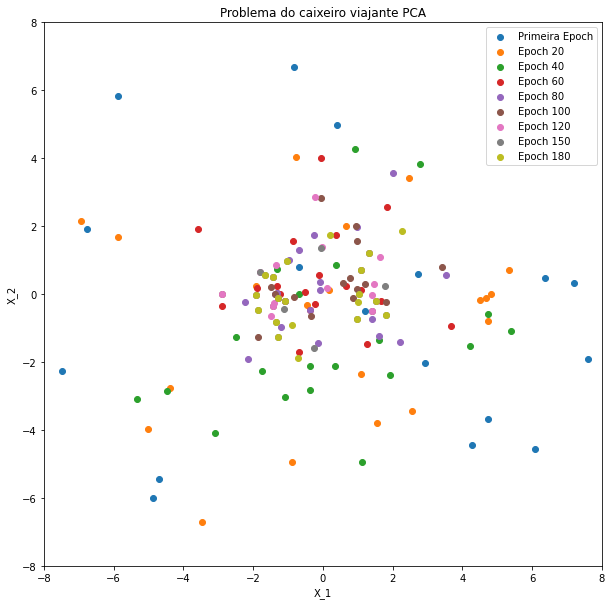

In [121]:
plt.figure(figsize = (10,10))
plt.scatter(*zip(*epoca_0), label = "Primeira Epoch")
plt.scatter(*zip(*epoca_20), label = "Epoch 20")
plt.scatter(*zip(*epoca_40), label = "Epoch 40")
plt.scatter(*zip(*epoca_60), label = "Epoch 60")
plt.scatter(*zip(*epoca_80), label = "Epoch 80")
plt.scatter(*zip(*epoca_100), label = "Epoch 100")
plt.scatter(*zip(*epoca_120), label = "Epoch 120")
plt.scatter(*zip(*epoca_150), label = "Epoch 150")
plt.scatter(*zip(*epoca_180), label = "Epoch 180")
plt.legend()
plt.title("Problema do caixeiro viajante PCA")
plt.ylabel("X_2")
plt.xlabel("X_1")
plt.ylim(-8,8)
plt.xlim(-8,+8)
#plt.savefig("pca_caixeiro_tudo_menos4.png")
plt.show()